In [30]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

In [31]:
dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", target_types="segmentation", download=False)

In [32]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

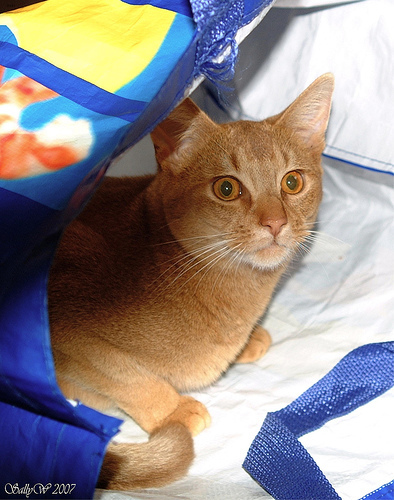

In [33]:
dataset[0][0]

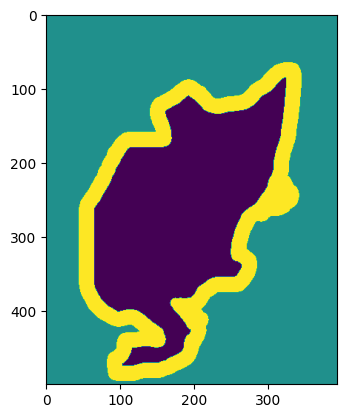

In [34]:
plt.imshow(dataset[0][1])

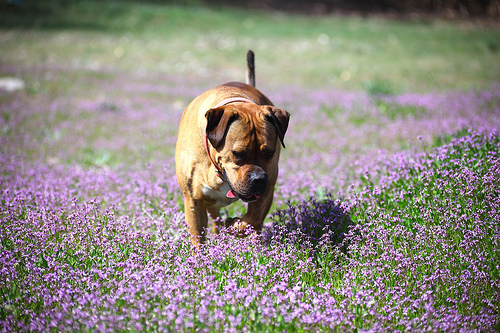

In [35]:
dataset[50][0]

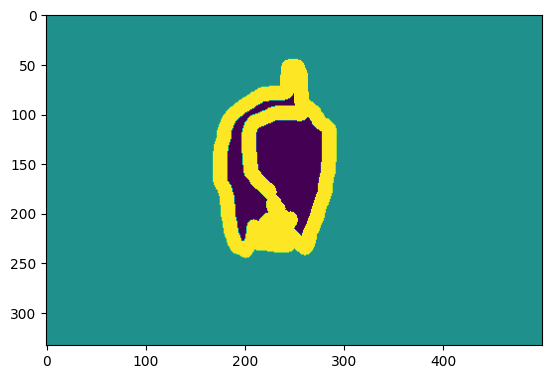

In [36]:
plt.imshow(dataset[50][1])

In [37]:
transforms = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
    ]
)

target_transforms = T.Compose(
    [
        T.Resize((128, 128)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

In [38]:
train_dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", transform=transforms, target_transform=target_transforms, target_types="segmentation")
valid_dataset = OxfordIIITPet("/content/drive/MyDrive/DLE/OxfordPets", transform=transforms, target_transform=target_transforms, target_types="segmentation", split="test")

In [39]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [40]:
def train(model, train_loader) -> tuple[float, float]:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc="Train"):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [41]:
@torch.inference_mode()
def evaluate(model, valid_loader) -> tuple[float, float]:
    model.eval()

    valid_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(valid_loader, desc="Evaluation"):
        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        valid_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += bs * y.size(1) * y.size(2)
        correct += (y_pred == y).sum().item()

    valid_loss /= len(valid_loader)
    accuracy = correct / total

    return valid_loss, accuracy

In [50]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):

    plt.figure(figsize=(10, 5))
    plt.title(title + " loss")

    plt.plot(train_loss, label="Trian loss")
    plt.plot(valid_loss, label="Valid_loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [81]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]
        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor="white")

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")

        ax[0].set_title("Origin image")
        ax[1].set_title("Segmentation mask")
        ax[2].set_title("Prediction")

        plt.subplots_adjust(wspace=0, hspace=0.2)
        plt.show()

        if i > 9:
            break

In [69]:
def whole_train_valid_cycle(model, num_epochs, title, sched=False):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(train_loss_history, valid_loss_history, train_accuracy_history, valid_accuracy_history, title)

        if sched:
            scheduler.step()

In [60]:
def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

In [61]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(in_channels=3, out_channels=base_channels)
        self.down2 = conv_plus_conv(in_channels=base_channels, out_channels=base_channels * 2)

        self.up1 = conv_plus_conv(in_channels=base_channels * 2, out_channels=base_channels)
        self.up2 = conv_plus_conv(in_channels=base_channels * 4, out_channels=base_channels)

        self.bottleneck = conv_plus_conv(in_channels=base_channels * 2, out_channels=base_channels * 2)
        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        residual1 = self.down1(x)
        x = self.downsample(residual1)

        residual2 = self.down2(x)
        x = self.downsample(residual2)

        x = self.bottleneck(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        x = self.out(x)

        return x

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.CrossEntropyLoss()

cuda


In [63]:
model = UNET().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10)

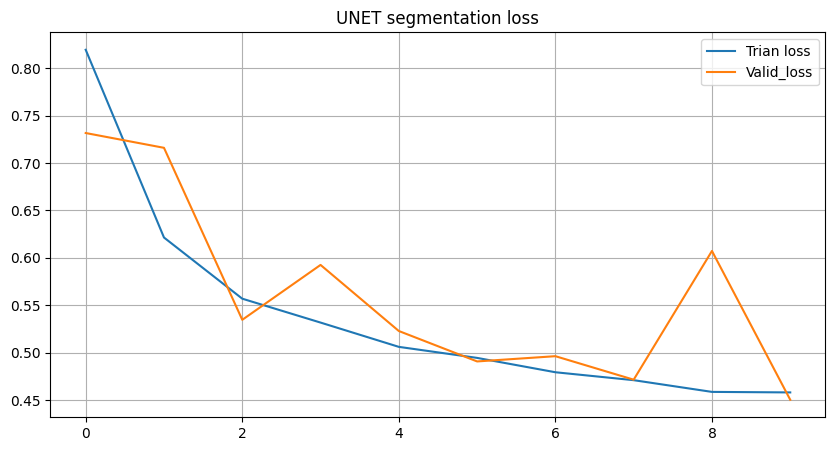

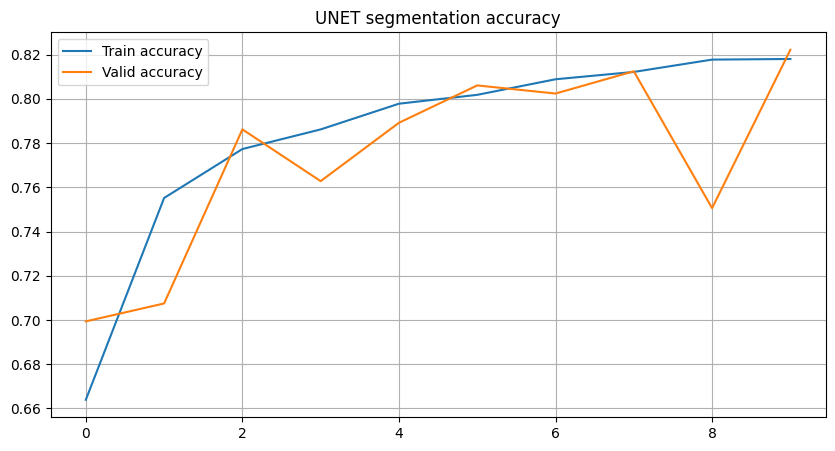

In [64]:
whole_train_valid_cycle(model, 30, "UNET segmentation")

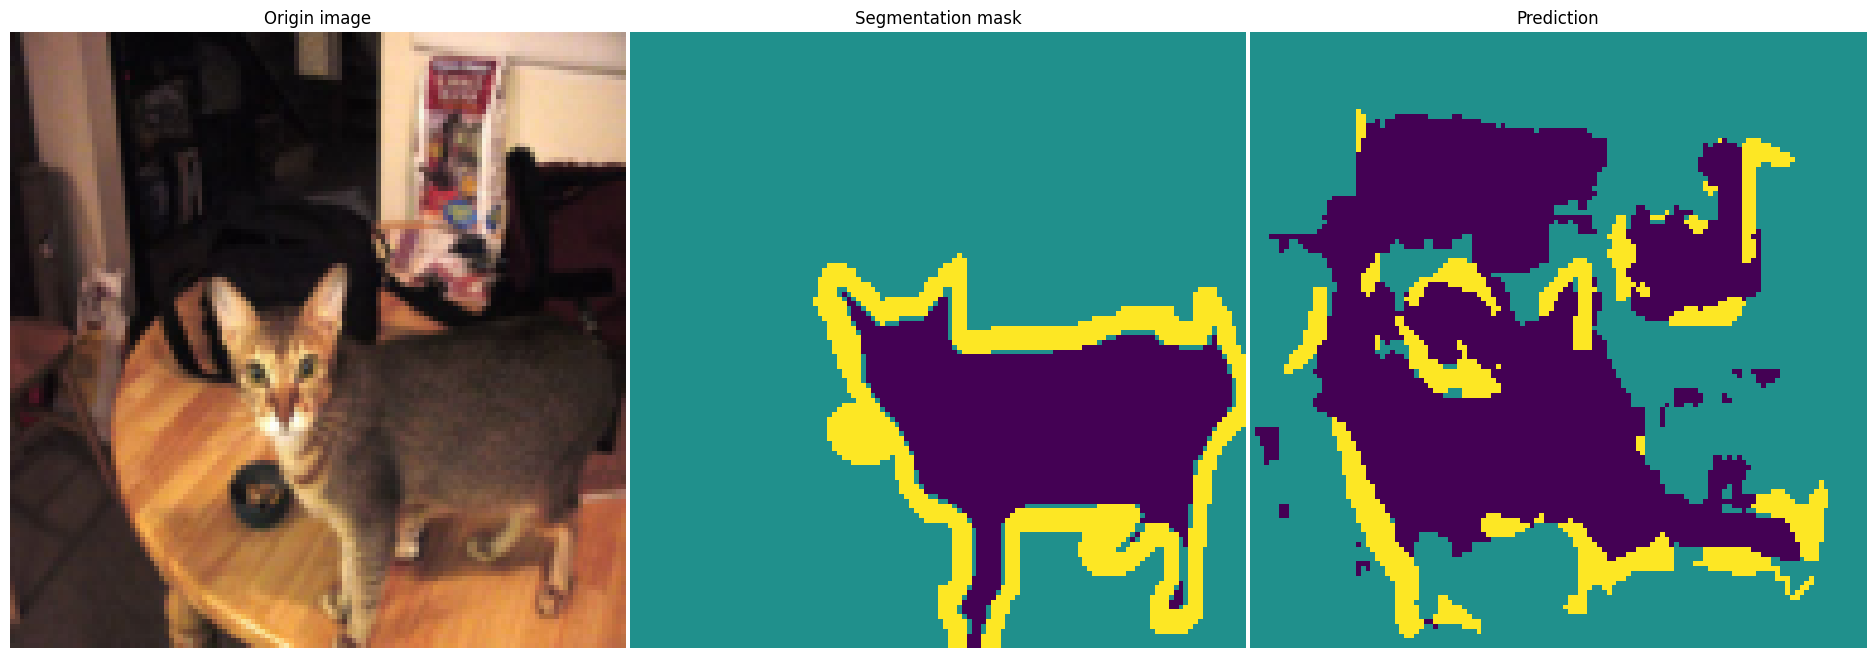

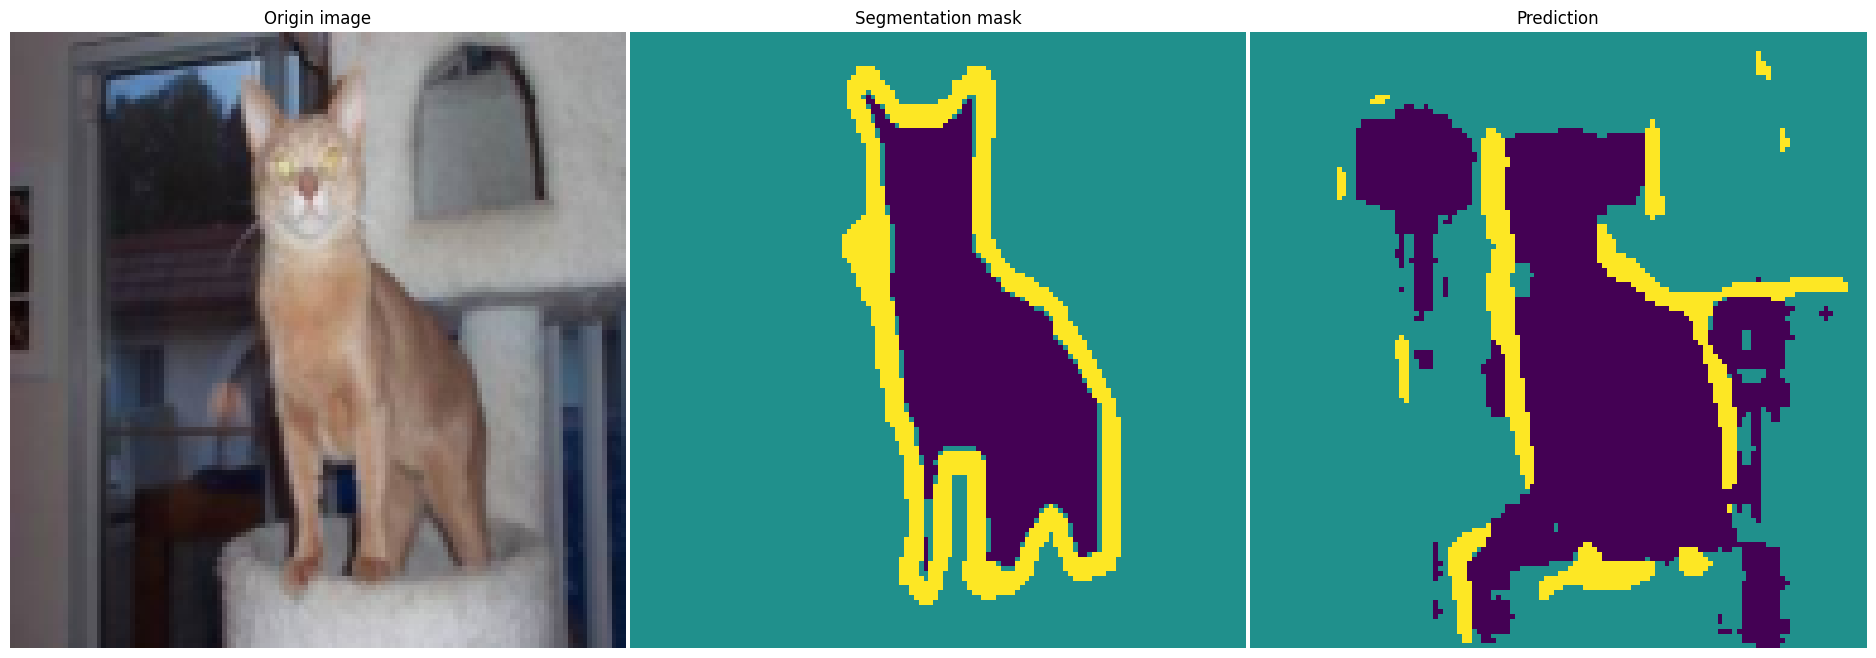

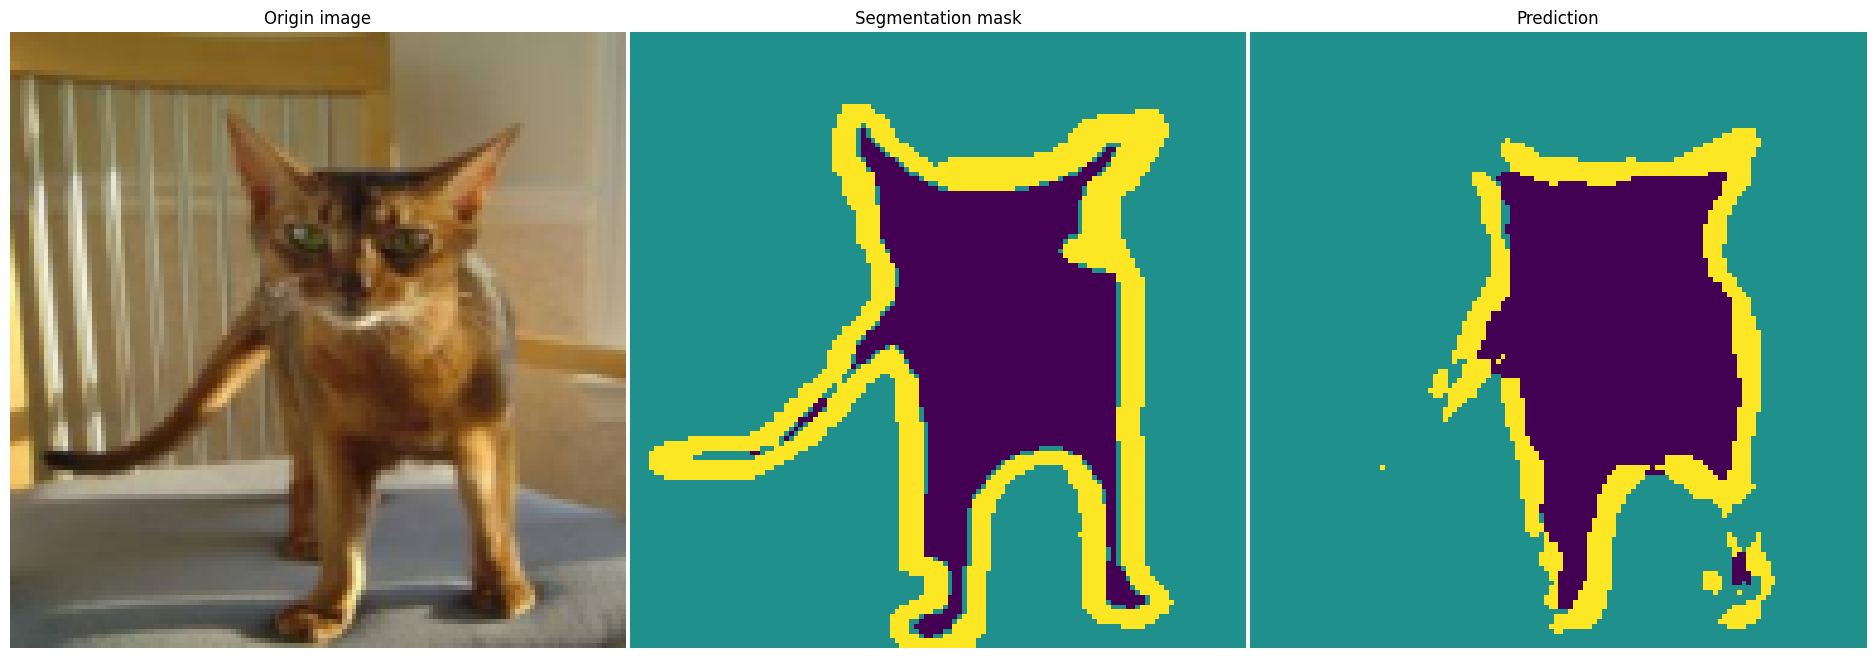

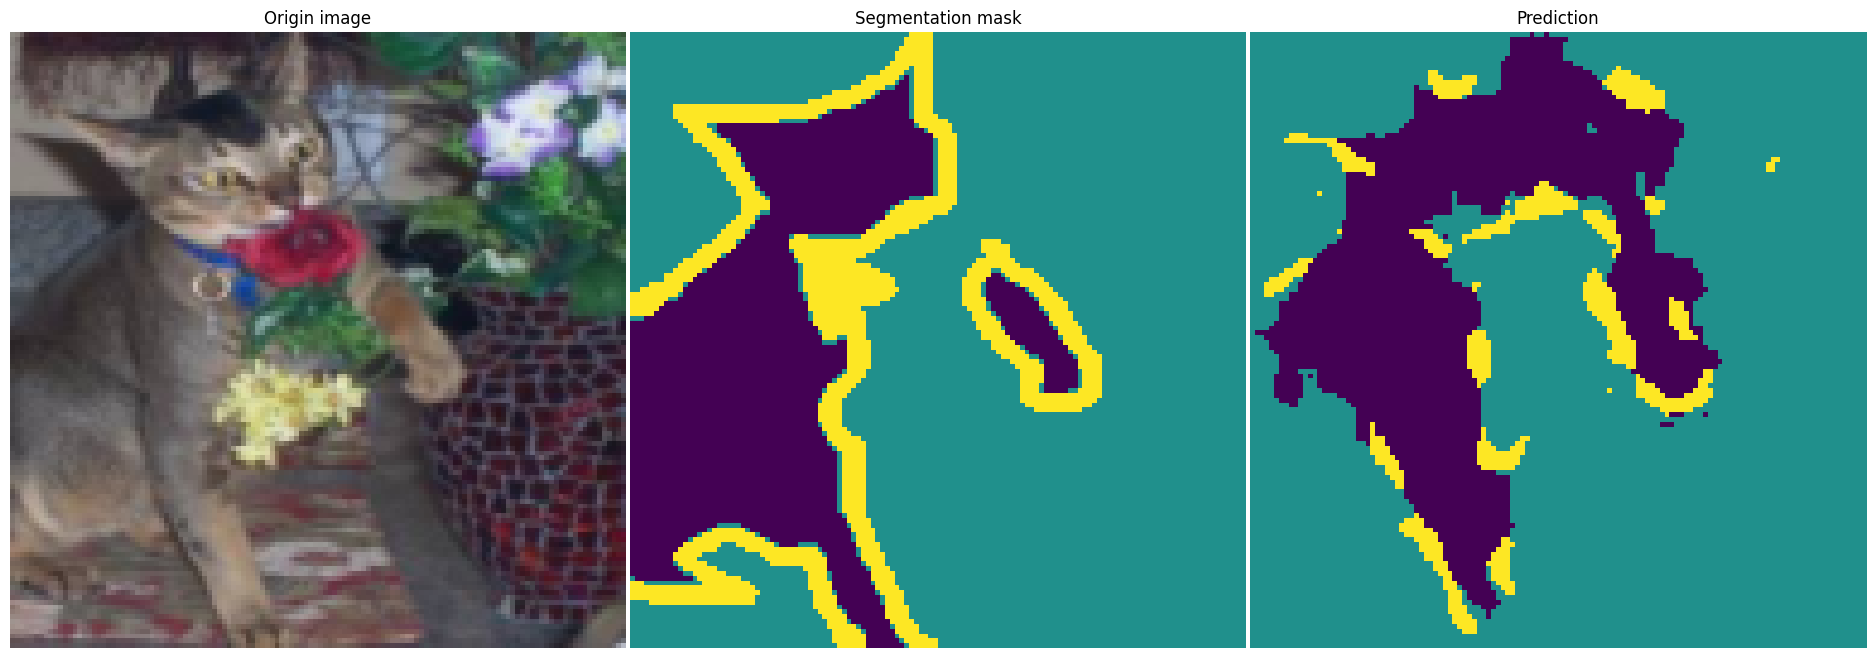

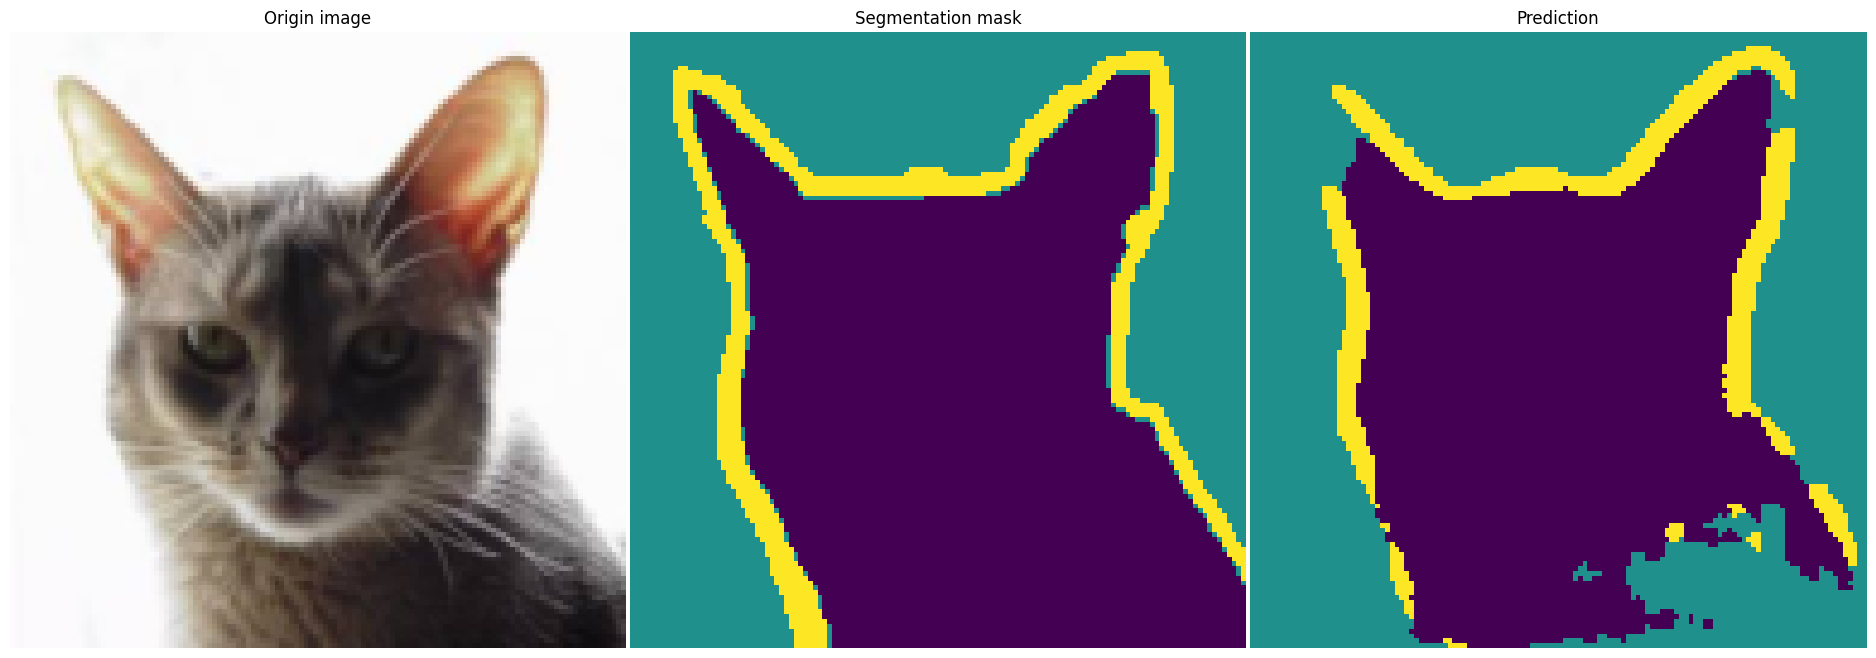

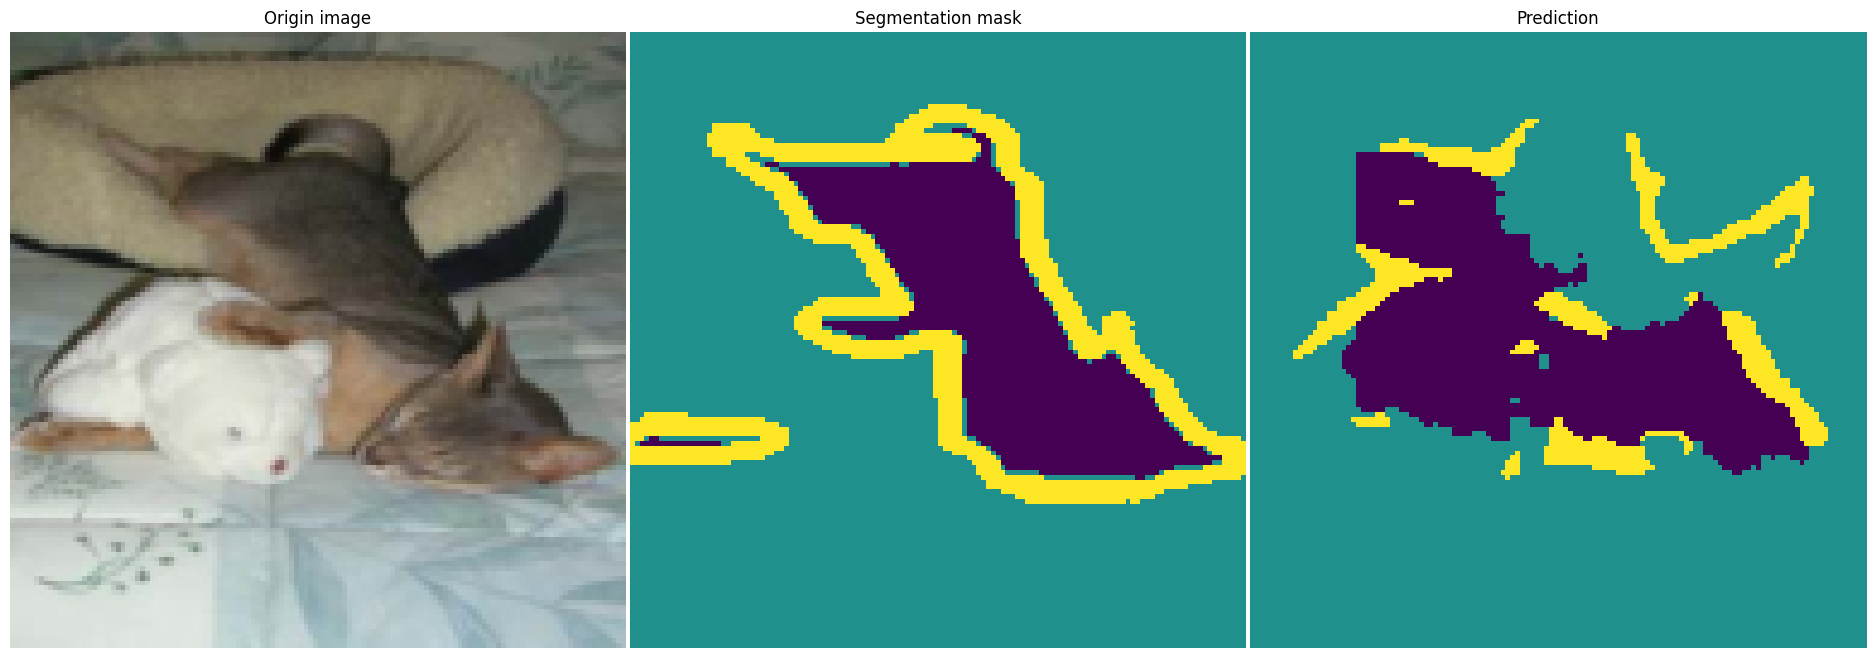

In [82]:
visualize(model, next(iter(valid_loader)))